In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing dataset
df= pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


## EDA

In [3]:
df.shape

(42, 2)

In [4]:
#check the datatypes
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [5]:
#check the descriptive statistics
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [6]:
#  information of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [7]:
# check any null values is there in the dataset
df.isnull().any()

Quarter    False
Sales      False
dtype: bool

In [8]:
# check any duplicated values is there
df.duplicated().any()

False

## Feature Engineering
### Converting the Quarters into Years

In [9]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


## Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)

In [10]:
# converting into datetime formate as the index was not in correct formate.
df['Date'] = (
    pd.to_datetime(
        df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


## Extracting the Quarters and putting in column

In [11]:
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


### Creating Dummy Variables for Quarters Variable

In [12]:
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


### Dropping all the unnecessary column

In [13]:
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


### Making the Date as DateTime index for the Dataframe

In [14]:
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [15]:
df1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


### Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

In [16]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988


## Data visualization

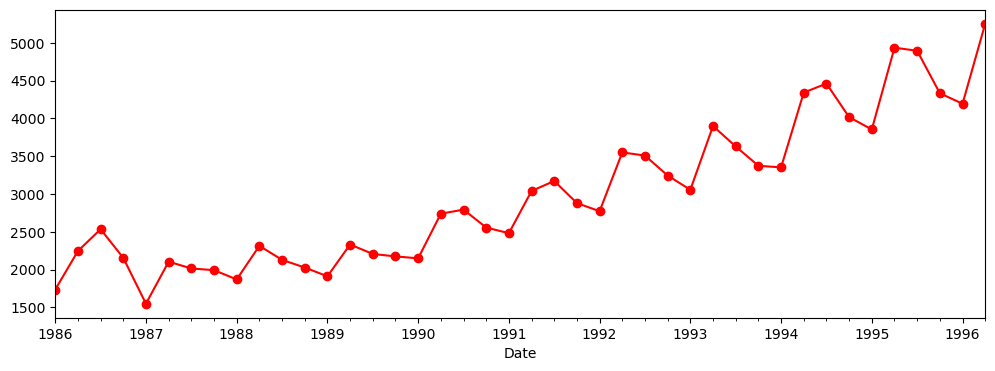

In [17]:
# plot the data
df1['Sales'].plot(figsize=(12, 4),color='red',marker='o')
plt.show()

<Axes: >

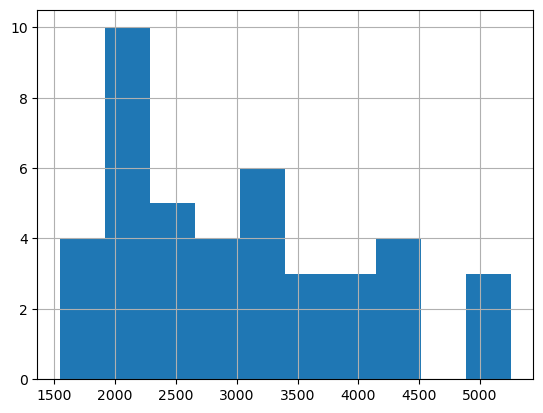

In [18]:
df['Sales'].hist()

<Axes: >

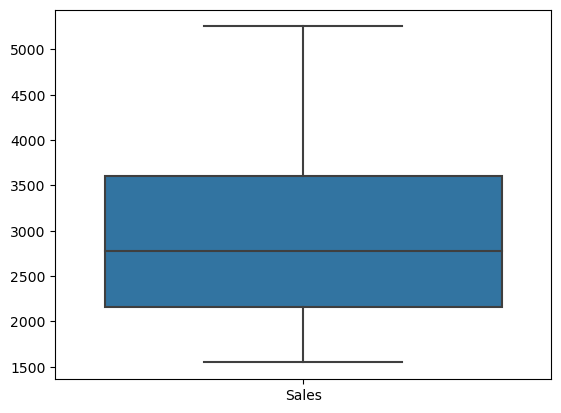

In [19]:
##Boxplot
sns.boxplot(data=df)

<Axes: ylabel='Density'>

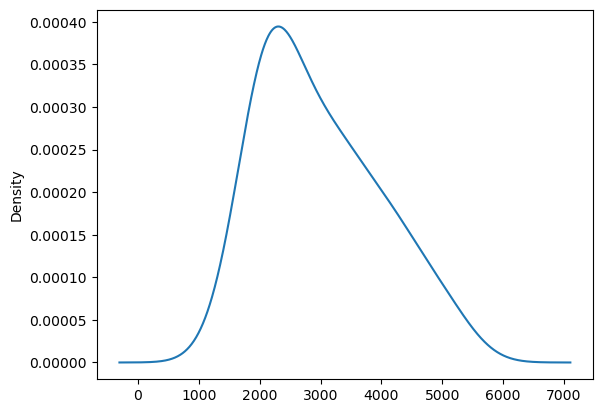

In [20]:
##Density plot
df['Sales'].plot(kind='kde')

<Axes: xlabel='Quarters', ylabel='Sales'>

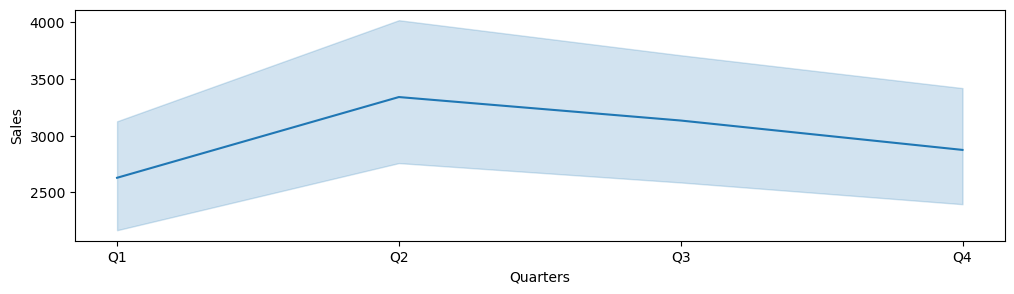

In [21]:
# line plot using Quarters as x axis and Sales as y axis
plt.figure(figsize=(12,3))
sns.lineplot(x="Quarters", y="Sales", data=df)

<Axes: xlabel='year', ylabel='Sales'>

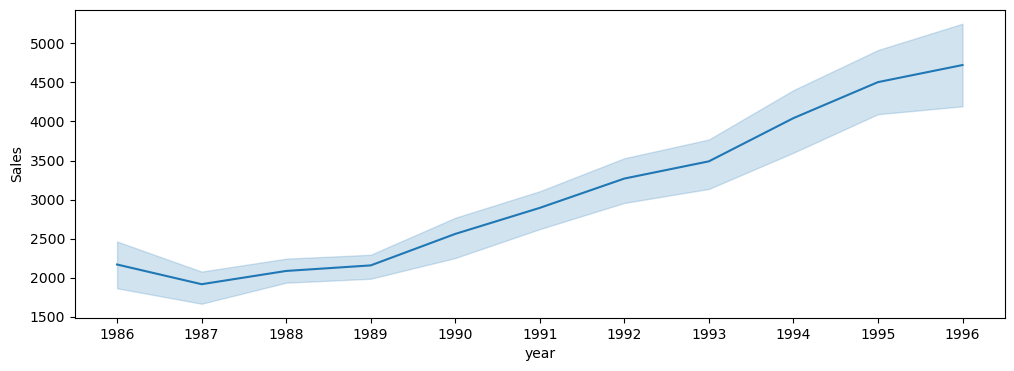

In [22]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)

### Box Plot of Each Year by Quaterly Intervals

<Axes: xlabel='year', ylabel='Sales'>

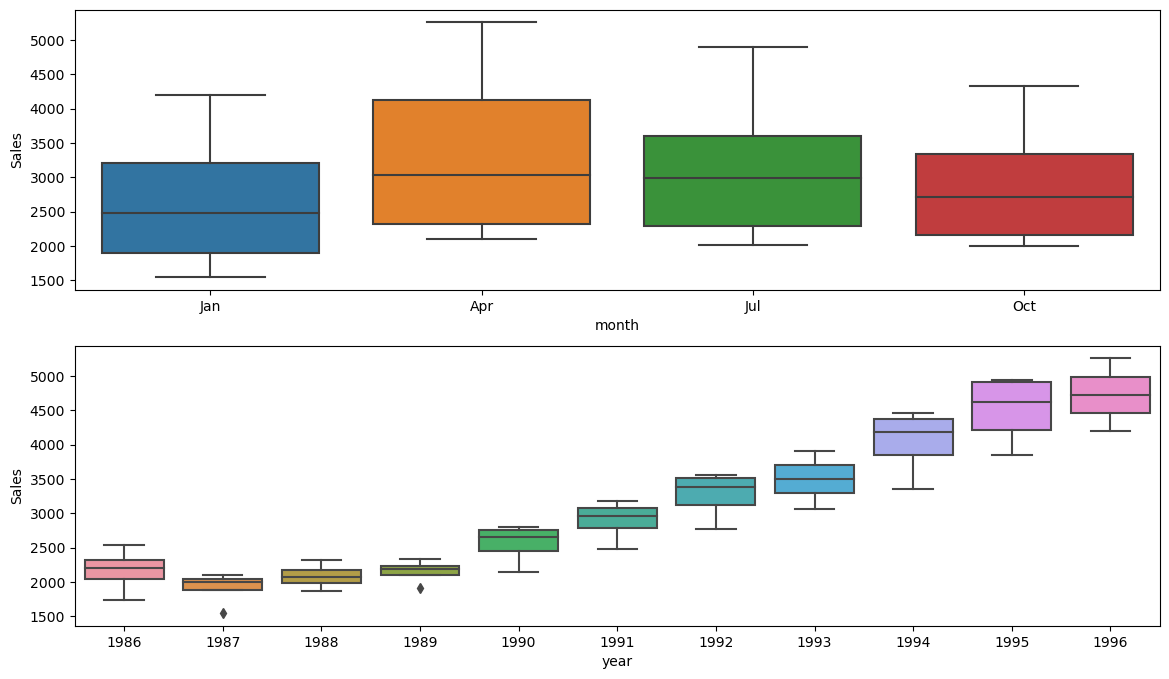

In [23]:
# Boxplot for ever
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=df)

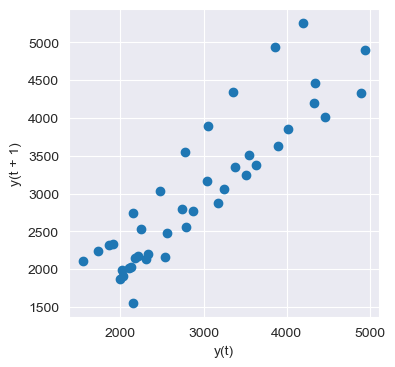

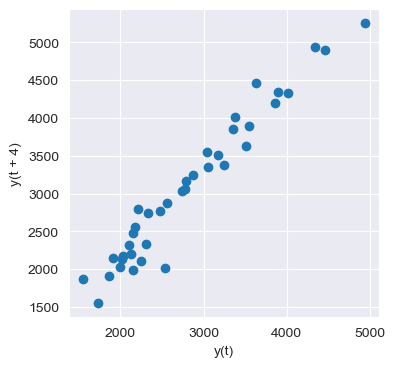

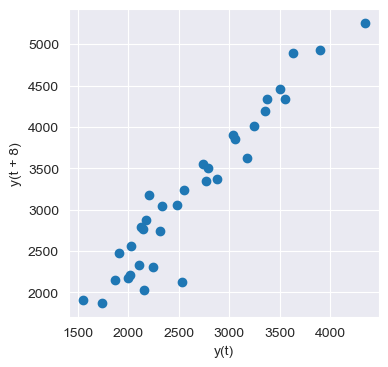

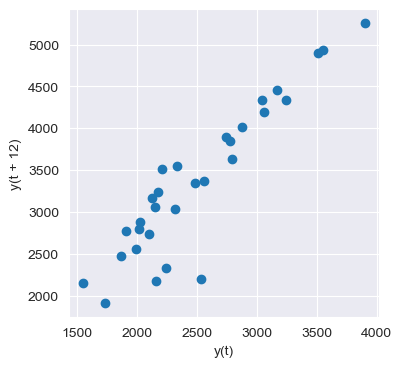

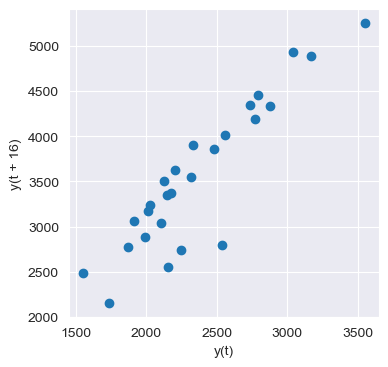

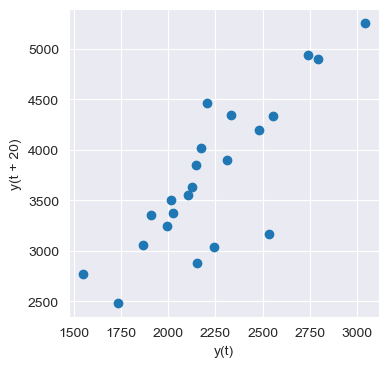

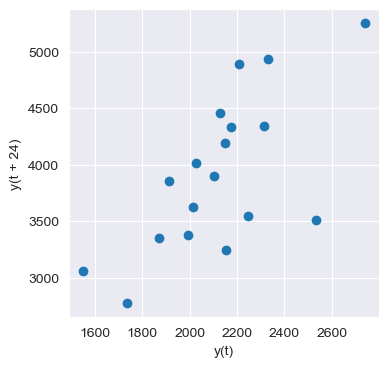

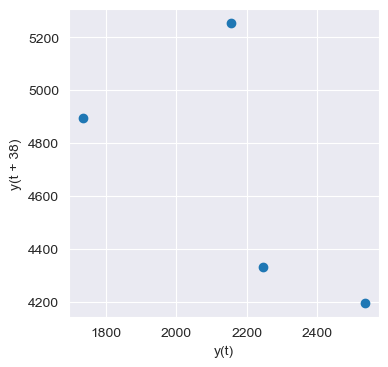

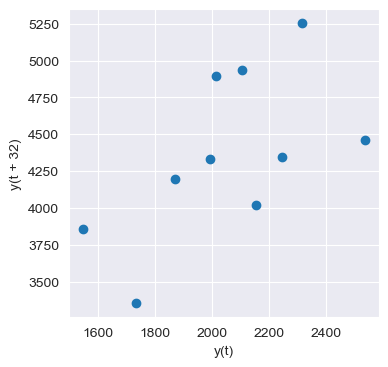

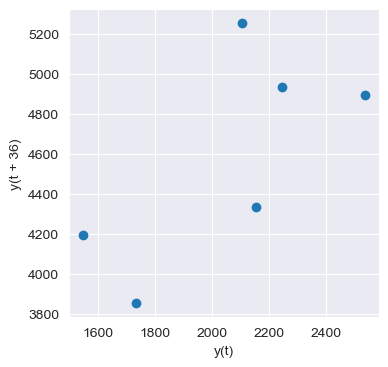

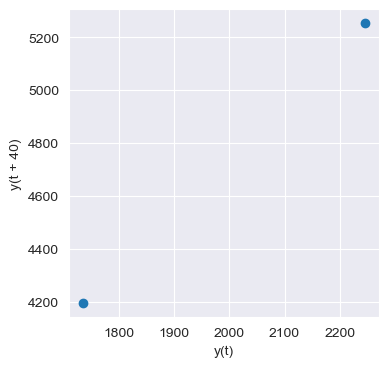

In [24]:
# create a scatter plot
from pandas.plotting import lag_plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    plt.figure(figsize=(4,4))
    sns.set_style(style='darkgrid')
    lag_plot(df.Sales, lag=i)
    plt.show()


## Moving Average

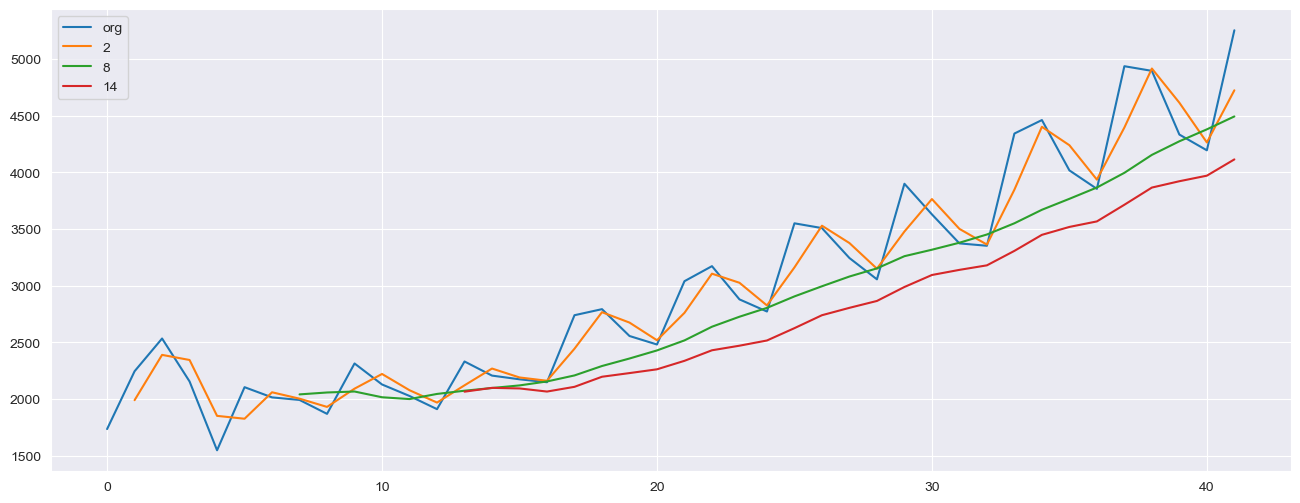

In [25]:
plt.figure(figsize=(16,6))
df.Sales.plot(label="org")
for i in range(2,20,6):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

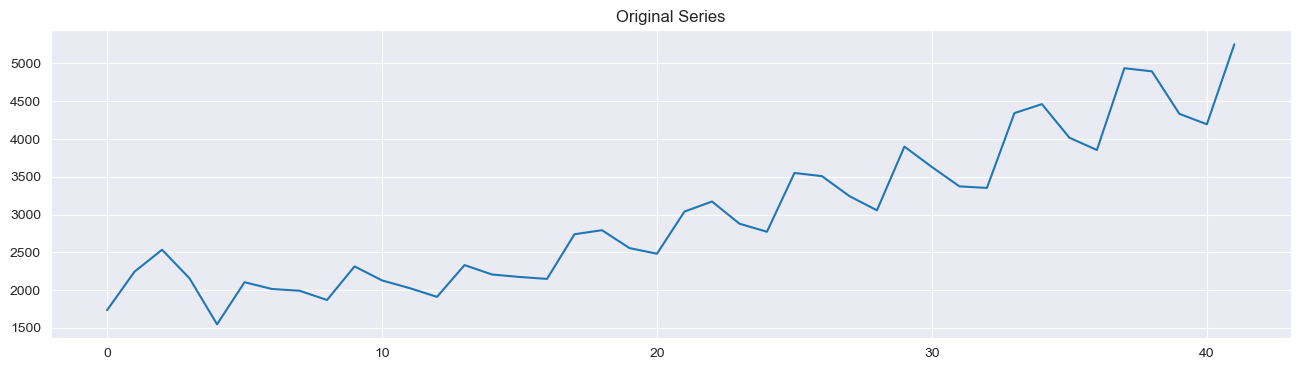

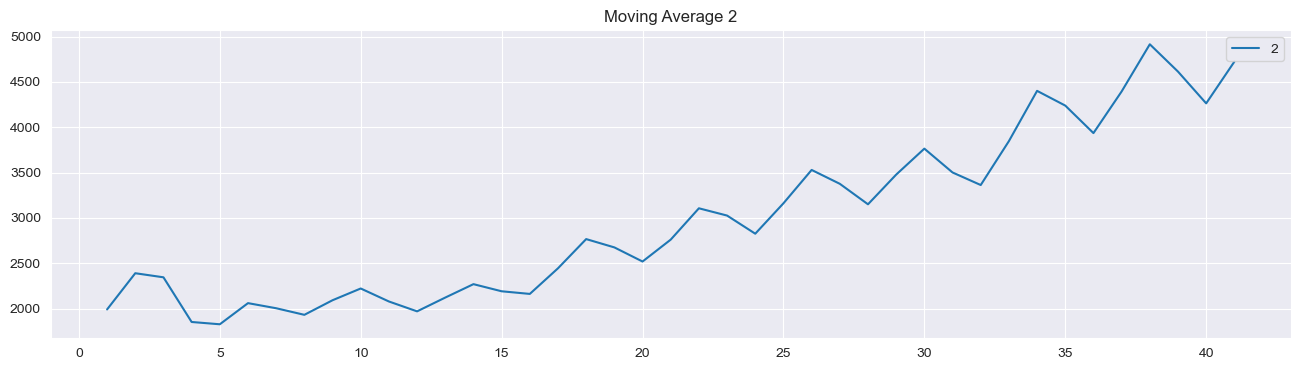

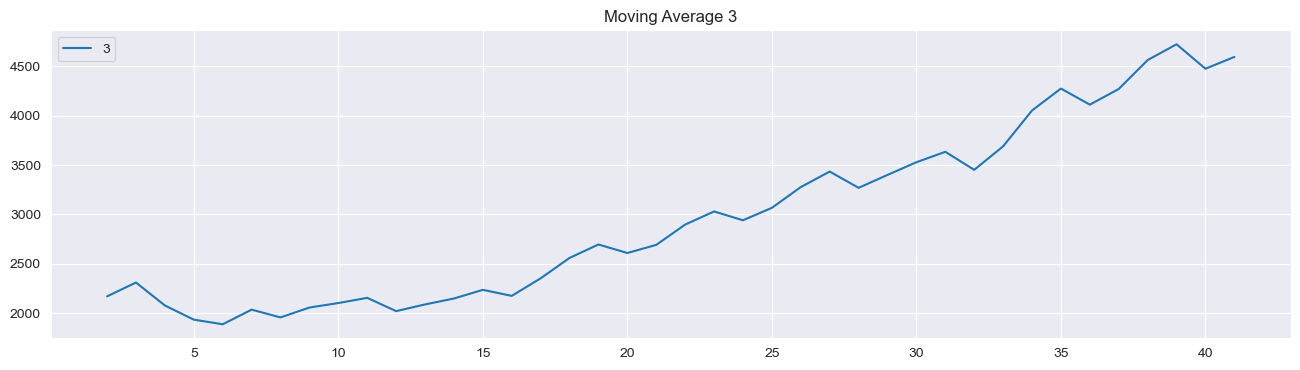

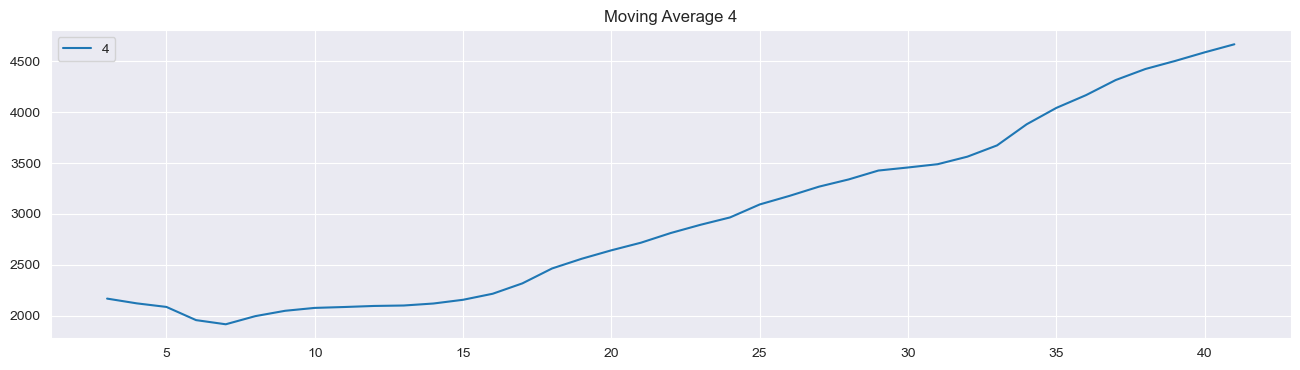

In [26]:
plt.figure(figsize=(16,4))
df.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,5):
    plt.figure(figsize=(16,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()


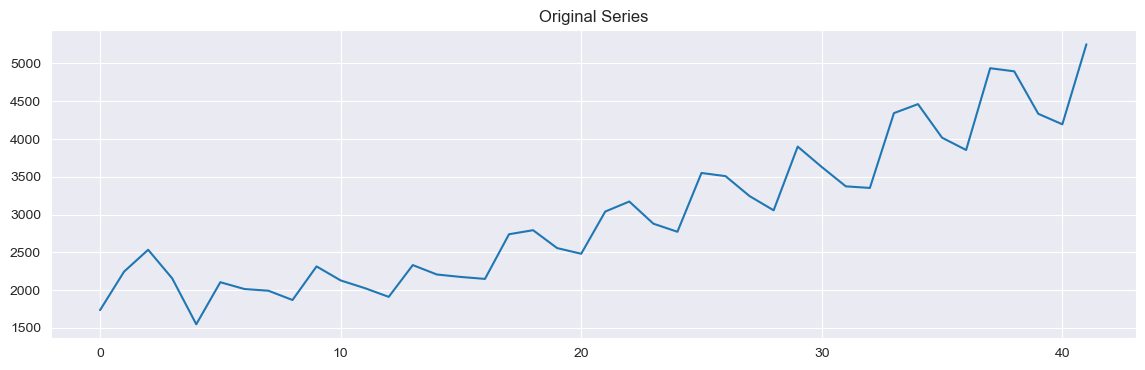

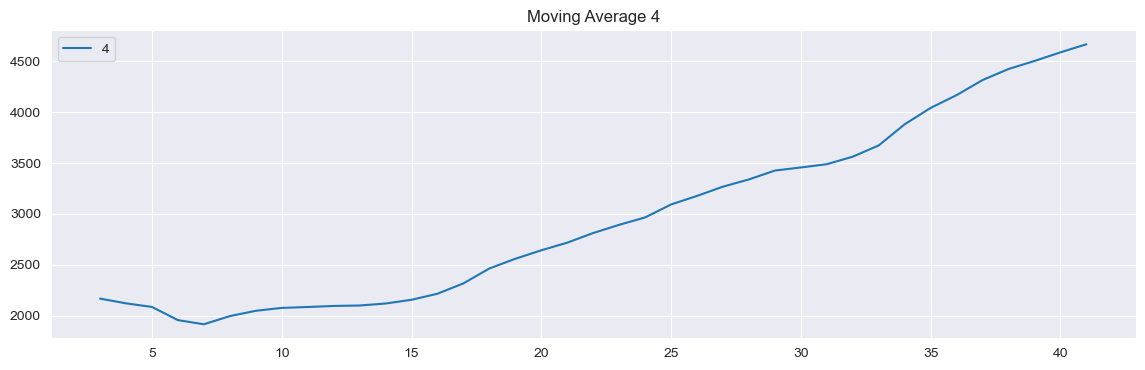

In [27]:
plt.figure(figsize=(14,4))
df.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(14,4))
df["Sales"].rolling(4).mean().plot(label=str(4))
plt.title("Moving Average "+str(4))
plt.legend(loc='best')
plt.show()

## Time series decomposition plot

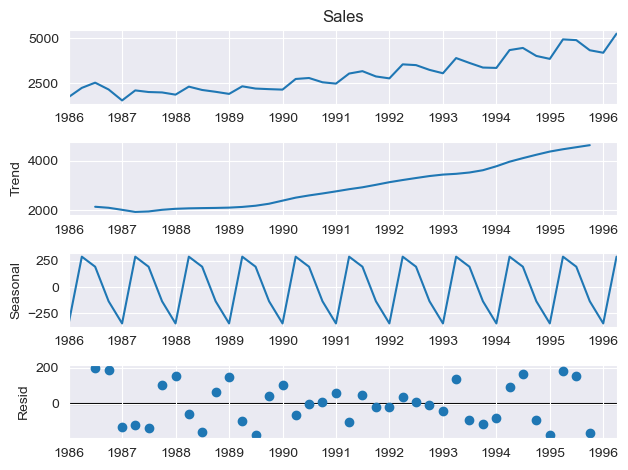

In [28]:
decompose_ts_add = seasonal_decompose(df1.Sales,period=4)

decompose_ts_add.plot()
plt.show()


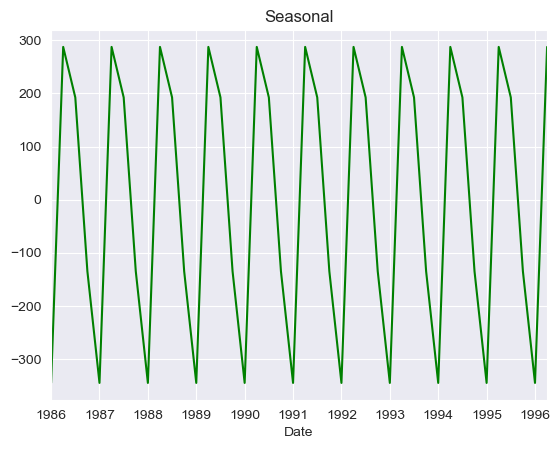

In [29]:
# seasonal plot
decompose_ts_add.seasonal.plot(color='green')
plt.title('Seasonal');

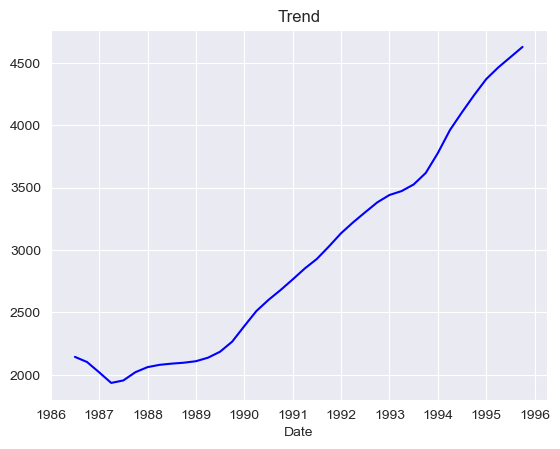

In [30]:
# Trend plot
decompose_ts_add.trend.plot(color='blue')
plt.title('Trend');

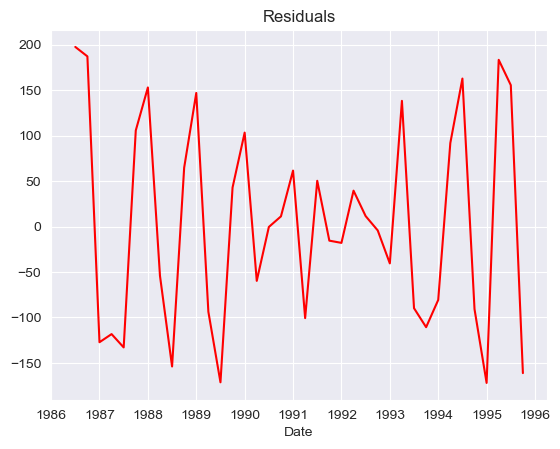

In [31]:
# residuals plot
decompose_ts_add.resid.plot(color='red')
plt.title('Residuals');

<Axes: xlabel='Date'>

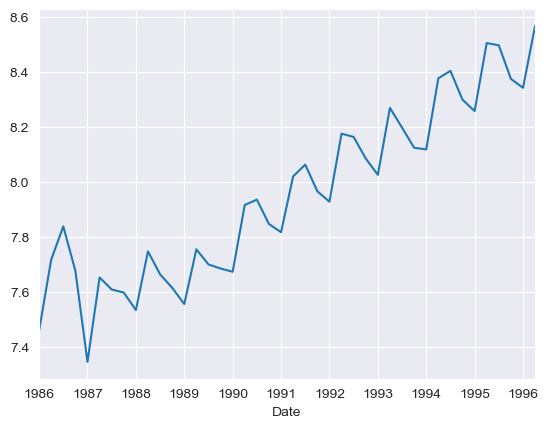

In [32]:
ts_data_log=np.log(df1.Sales)
ts_data_log.plot()

## ACF plots and PACF plots

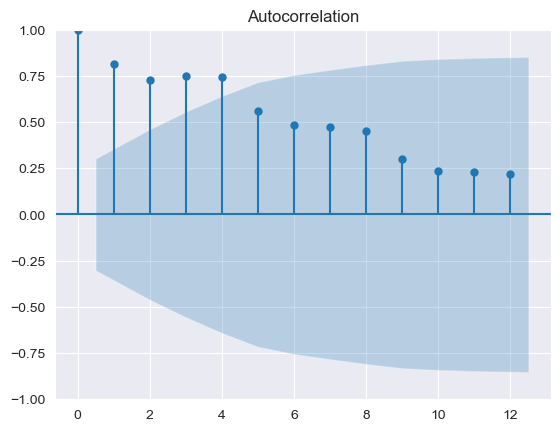

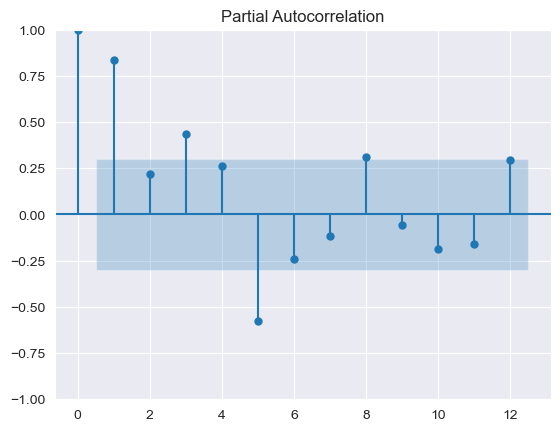

In [33]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df.Sales,lags=12)
tsa_plots.plot_pacf(df.Sales,lags=12)
plt.show()

## Linear interpolation
####  You draw a straight line joining the next and previous points of the missing values in the data.

## Upsampling with respect to month

In [34]:
upsampled_month = df1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996
1987-02-28  1733.349996
1987-03-31  1918.880995


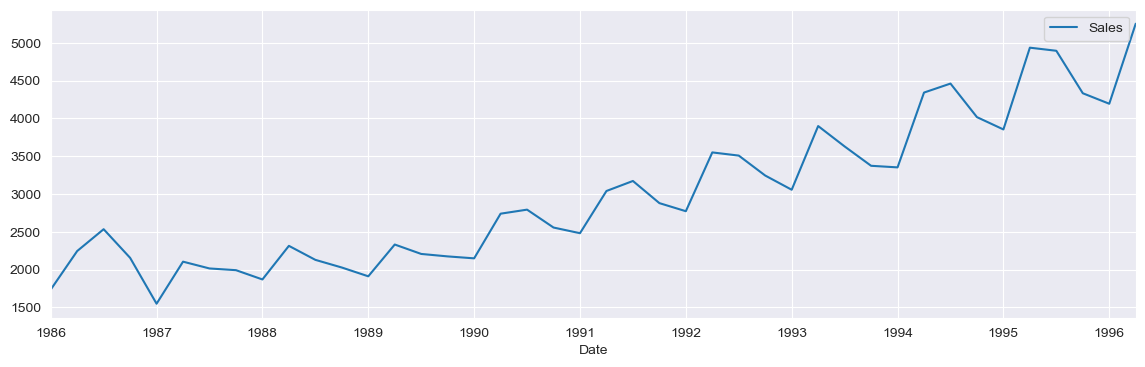

In [35]:
interpolated_month = upsampled_month.interpolate(method='linear') 
## interplation was done for nan values which we get after doing upsampling by month
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(14,4))
plt.show()

In [36]:
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


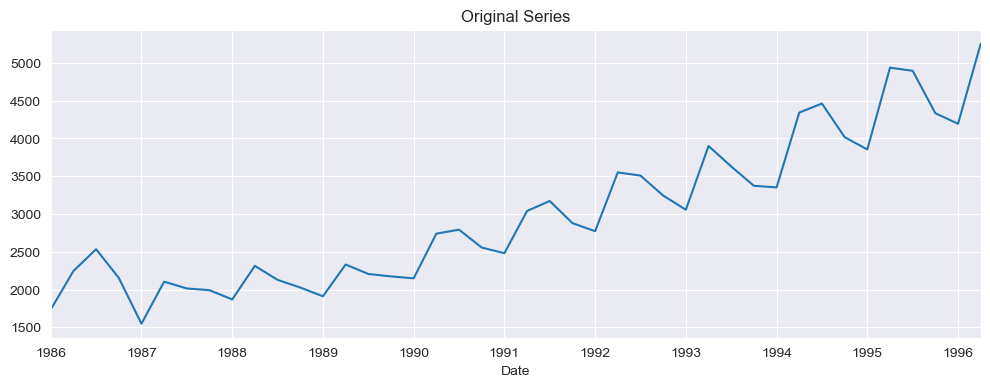

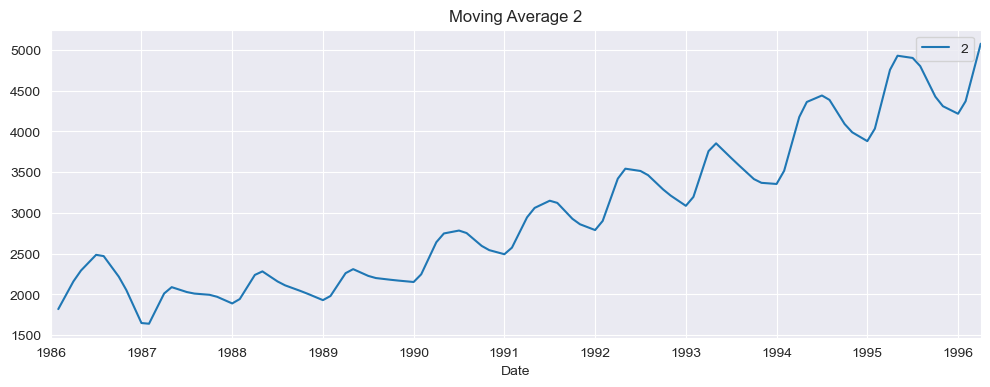

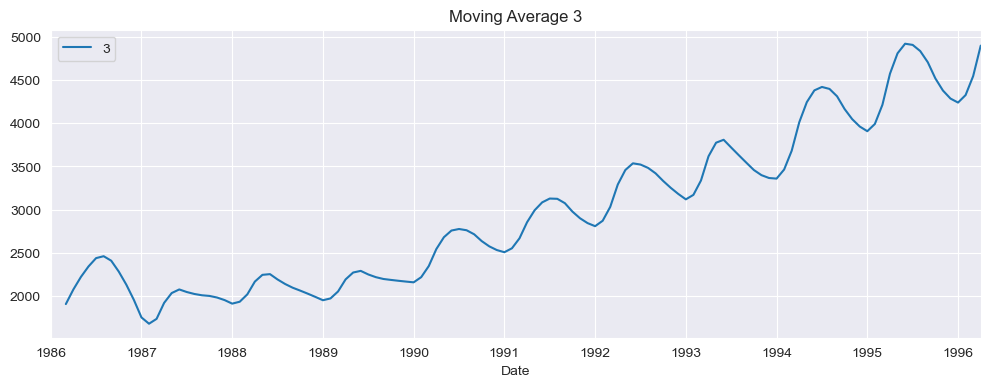

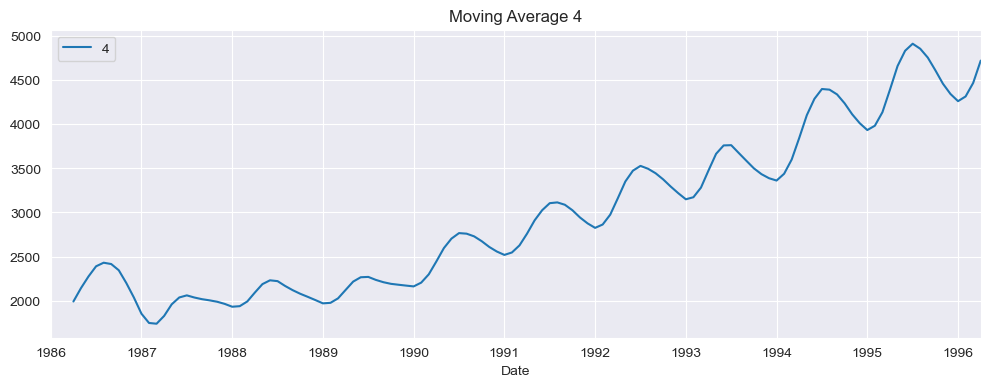

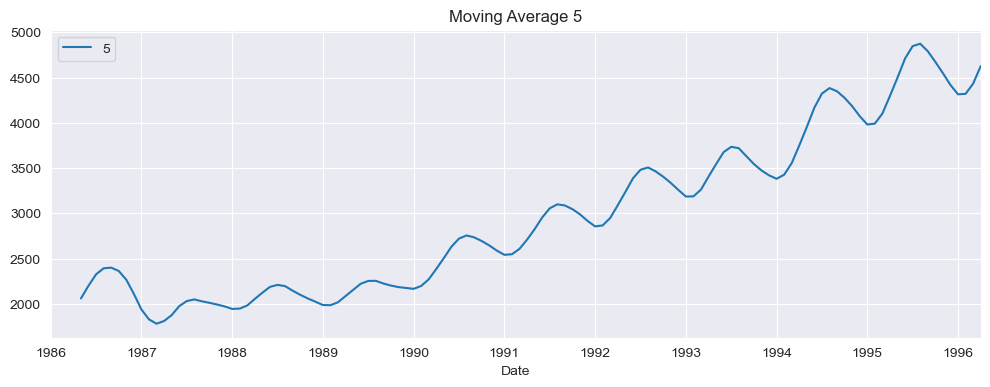

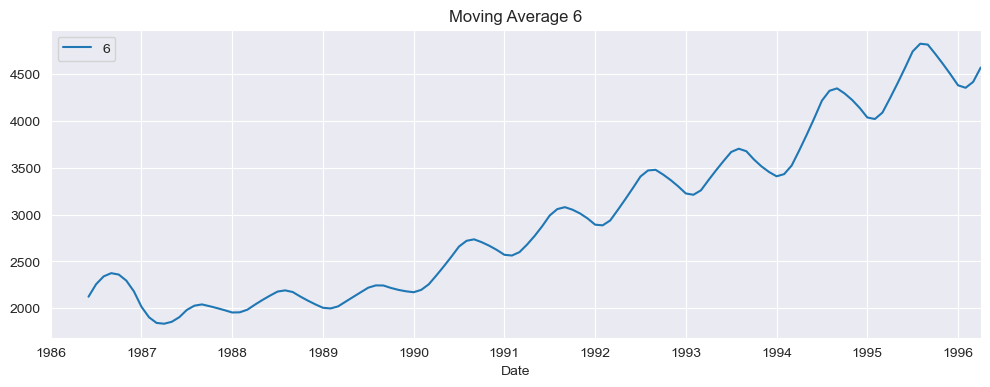

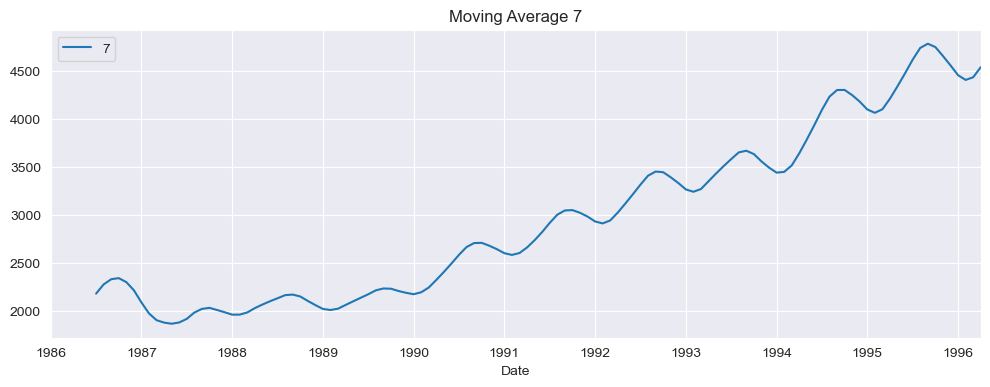

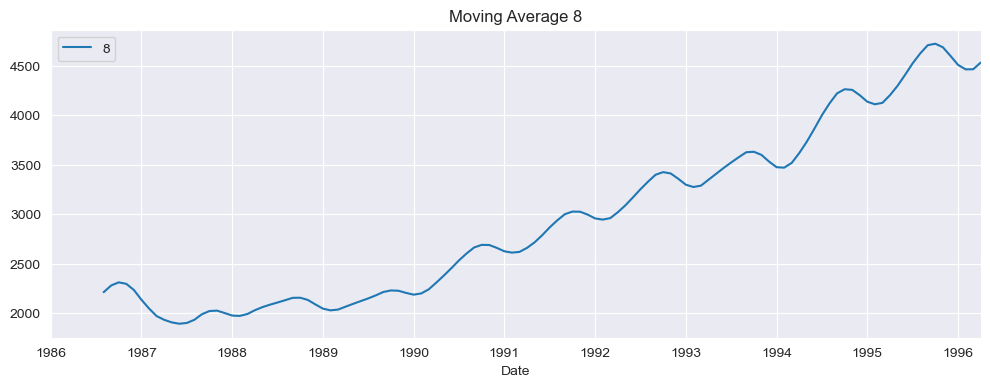

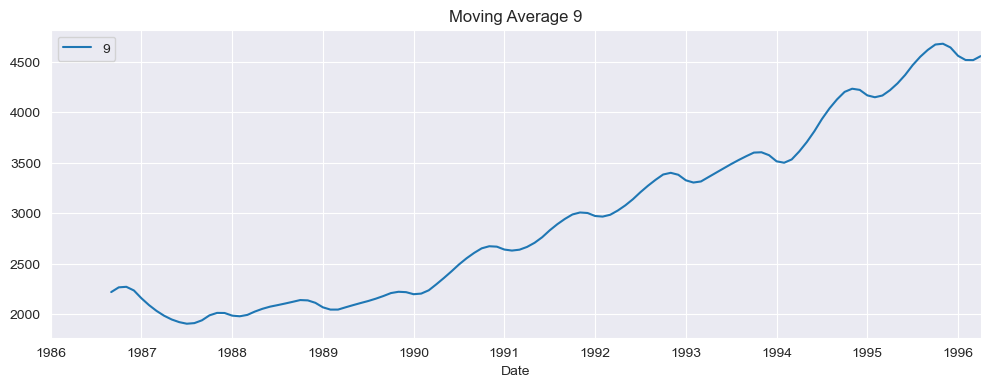

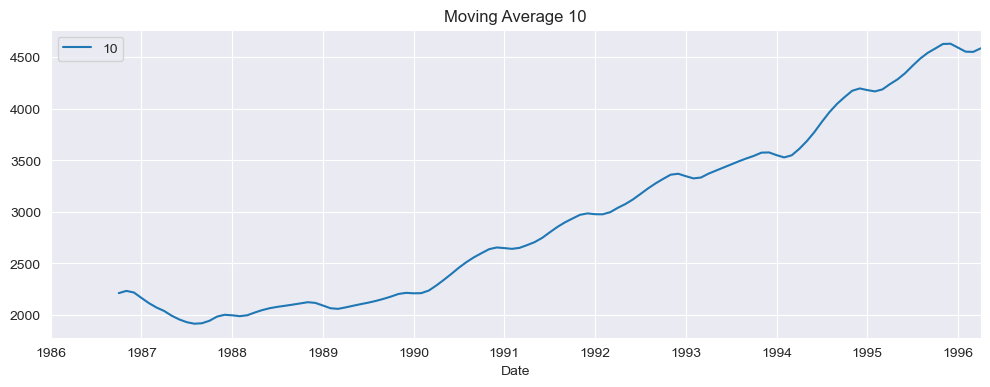

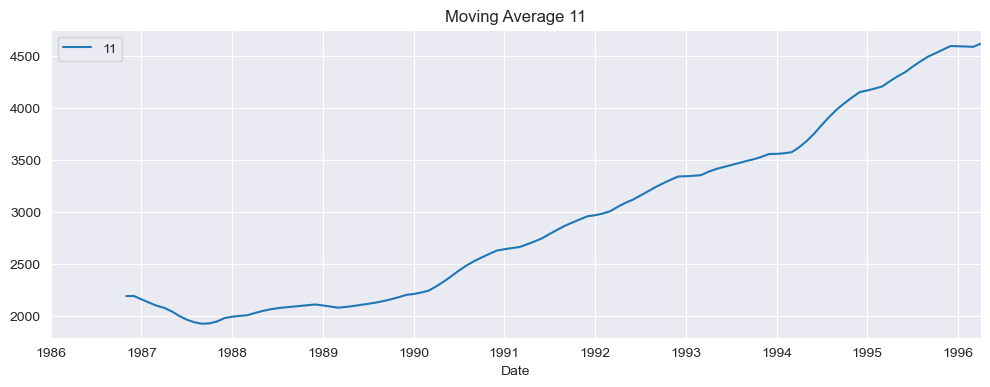

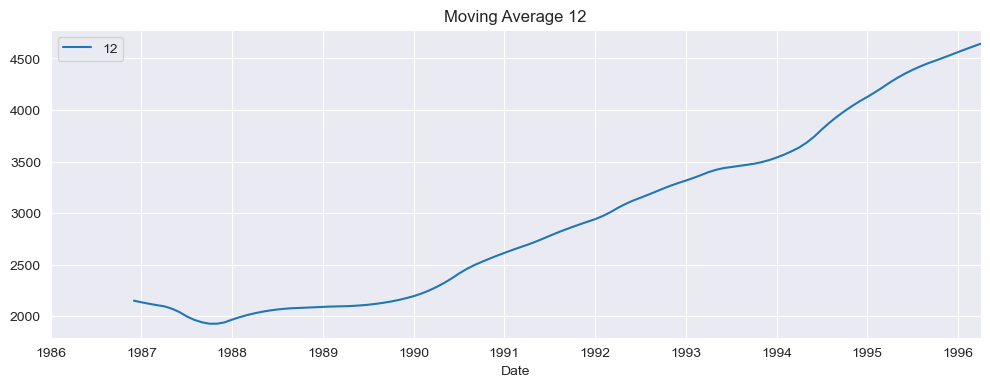

In [37]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(12,4))
    interpolated_month["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

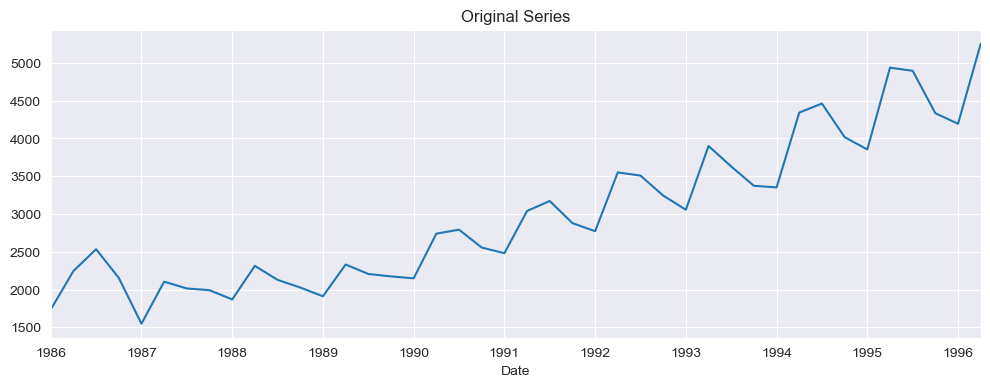

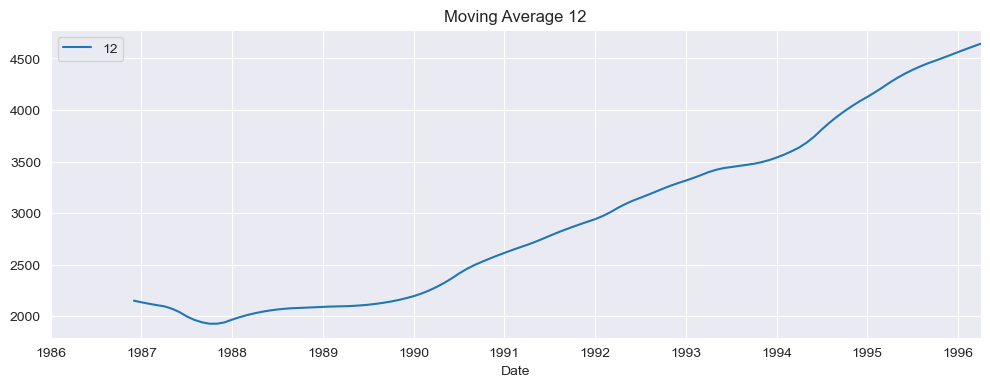

In [38]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
interpolated_month["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

## Additive Seasonal Decomposition

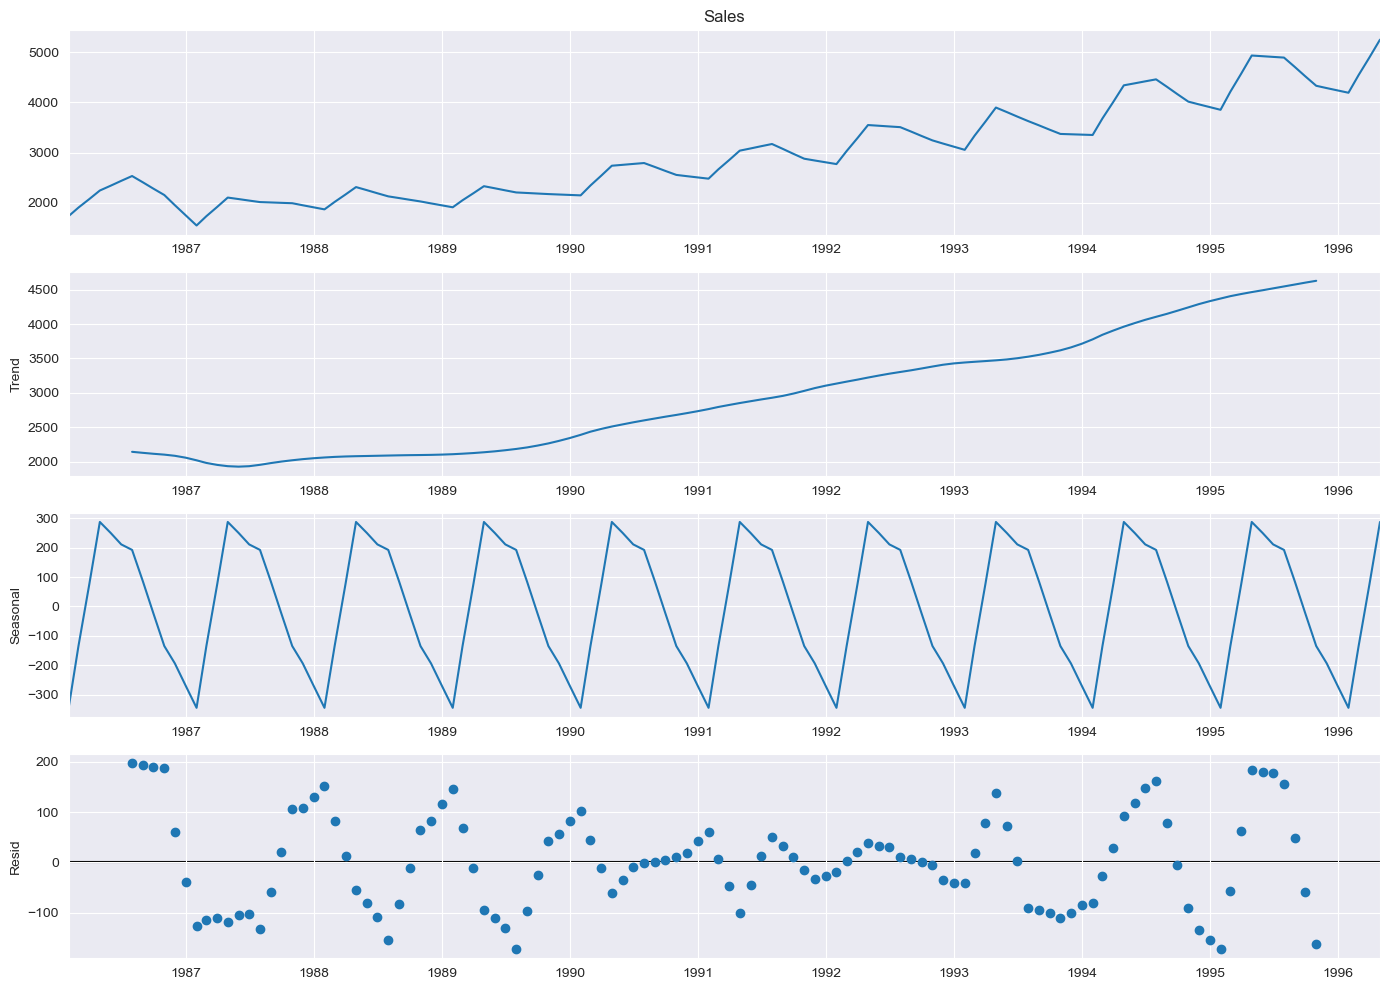

In [39]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='additive')
plt.rc("figure", figsize=(14,10))
decompose_ts_add.plot()
plt.show()


## Multiplicative Seasonal Decomposition

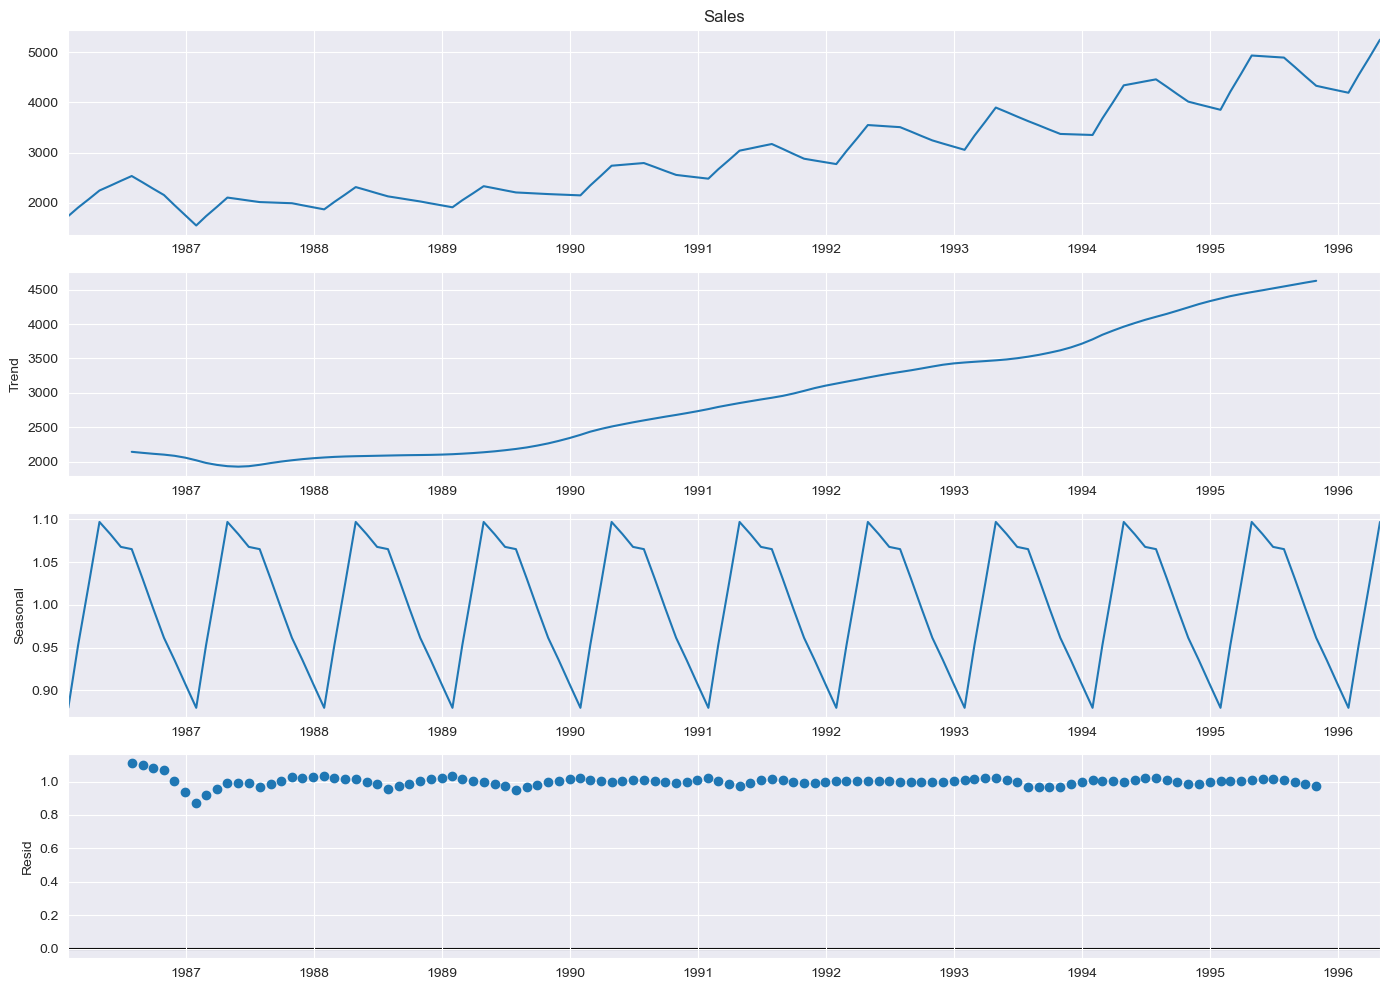

In [40]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='multiplicative')
plt.rc("figure", figsize=(14,10))
decompose_ts_add.plot()
plt.show()


In [41]:
#check the data is stationary or not
def test_stationarity(timeseries):
    
    #Calculate rolling mean and rolling standard deviation
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    plt.figure(figsize=(5,4))
    original = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'green', label = 'Rolling Std')
    plt.legend(loc='best')
    
    
    print('Results of Dickey-Fuller Test :\n')
    df_test = adfuller(timeseries)
    my_output = pd.Series(df_test[0:4], index =['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for i,j in df_test[4].items():
        my_output['Critical Value (%s)'%i] = j
    print(my_output)

## Augmented Dicky Fuller Test
#Null Hypothesis (H0): The series is not stationary

#p-val > 0.05

#Alternate Hypothesis (H1): The series is stationary

#p-val <= 0.05

Results of Dickey-Fuller Test :

Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


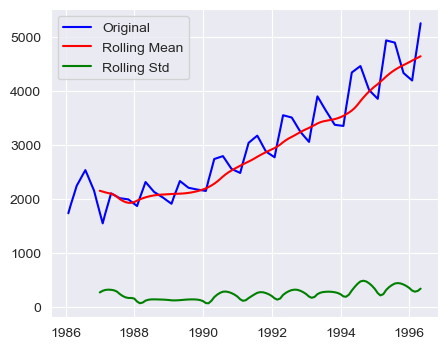

In [42]:
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)


In [43]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [44]:
adf_test(sales.Sales)

Fail to reject the null hypothesis
Data is non-stationary


## Feature Scaling (Transformations)
#Square Root Transform

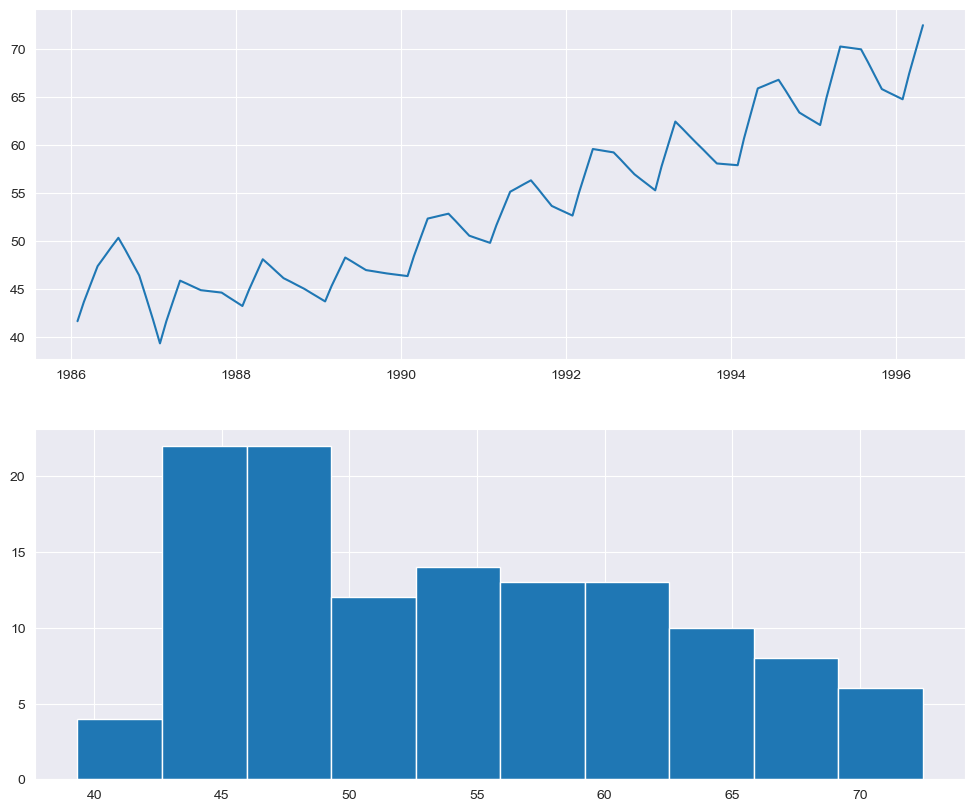

In [45]:
square_root= pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()

Results of Dickey-Fuller Test :

Test Statistic                   0.728012
p-value                          0.990381
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


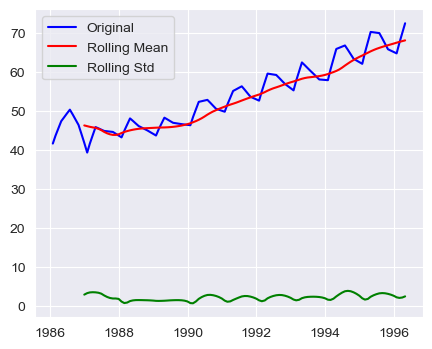

In [46]:
test_stationarity(square_root)

In [47]:
adf_test(square_root.Sales)

Fail to reject the null hypothesis
Data is non-stationary


## Log Transform

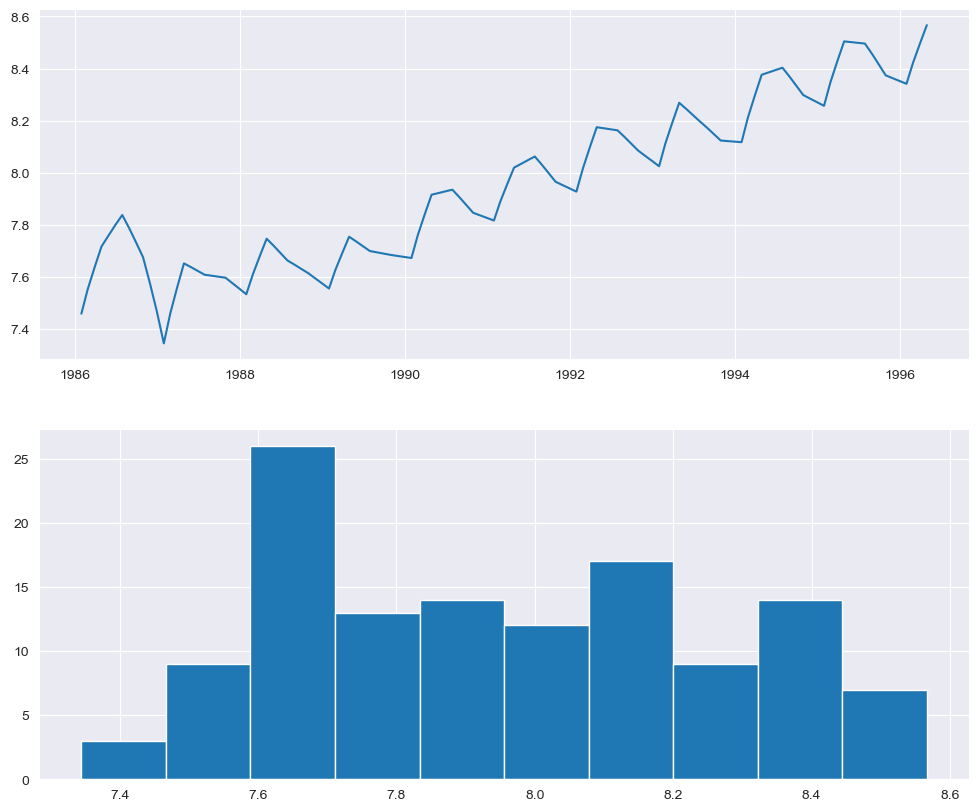

In [48]:
log = pd.DataFrame()
log = interpolated_month[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])
#Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()

Results of Dickey-Fuller Test :

Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


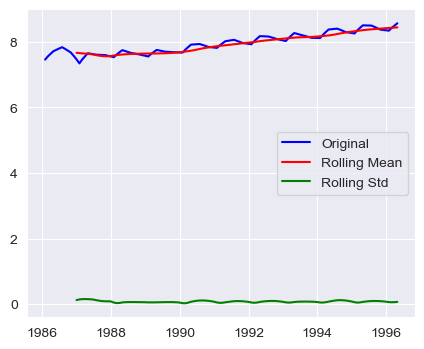

In [49]:
test_stationarity(log)

In [50]:
adf_test(log.Sales)

Fail to reject the null hypothesis
Data is non-stationary


Hence, the Time series data is Non-Stationary

## Converting Non-Stationary Time Series into Stationary
### Box Cox Transformation

,Sales
Date,
1986-01-31,7.458663
1986-02-28,7.552170
1986-03-31,7.637676
1986-04-30,7.716443
1986-05-31,7.758437


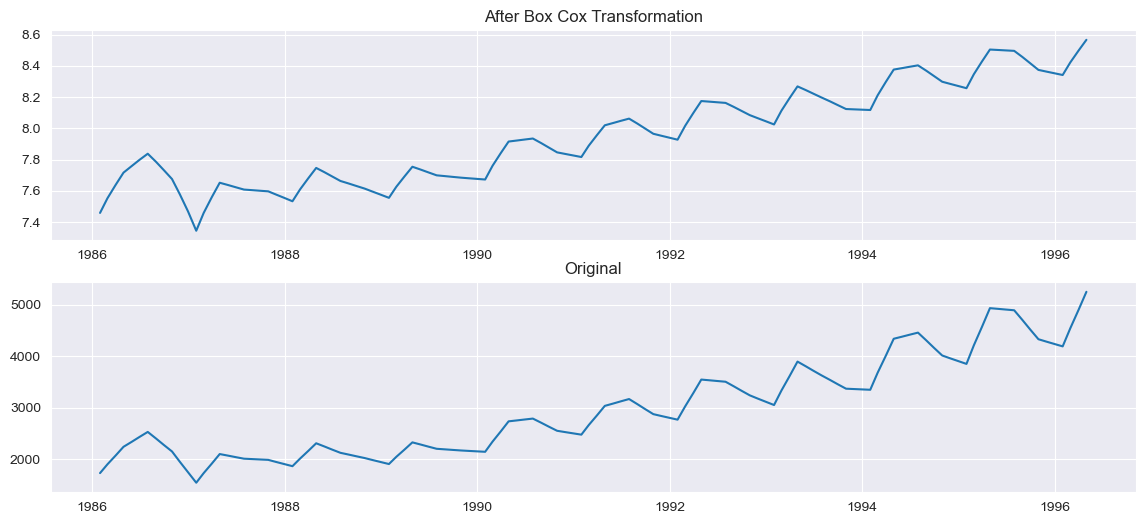

In [51]:
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()

Results of Dickey-Fuller Test :

Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


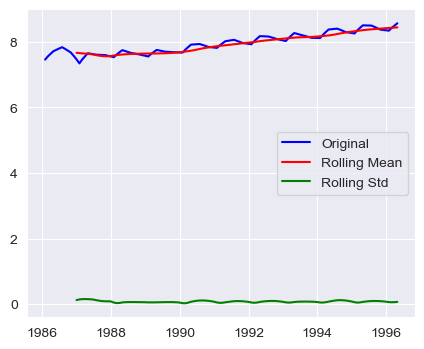

In [52]:
test_stationarity(data_boxcox)

In [53]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


## Differencing of the Box-Cox Transformation
Differencing is performed by subtracting the previous observation from the current observation.

Differencing removes trend and seasonality in a Time series. When an entire cycle is used for differencing the other cycle, then the seasonality is removed.

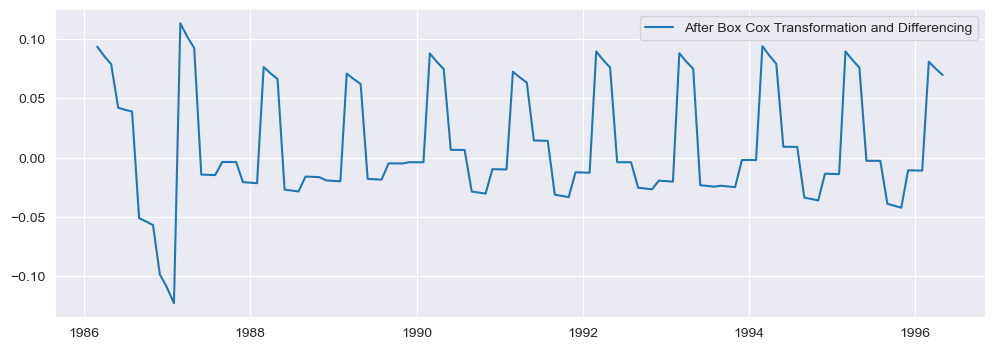

In [54]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

Results of Dickey-Fuller Test :

Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


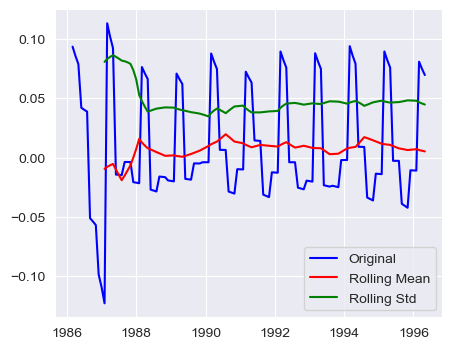

In [55]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)

In [56]:
adf_test(data_boxcox_diff.Sales)

Reject the null hypothesis
Data is stationary


Finally, Our Series is now stationary for AR Forecasting

### Splitting Train and Test Data


In [57]:
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]

## Building The Time Series Forecasting with Optimal Value using ARIMA
Automatically performs the Differencing if the series has trend.

Hence, no need to manually perform the differencing.

In [58]:
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

In [59]:
model = sm.tsa.arima.ARIMA(train_data_boxcox_diff, order=(3, 0, 2))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].add(data_boxcox.Sales[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast'])

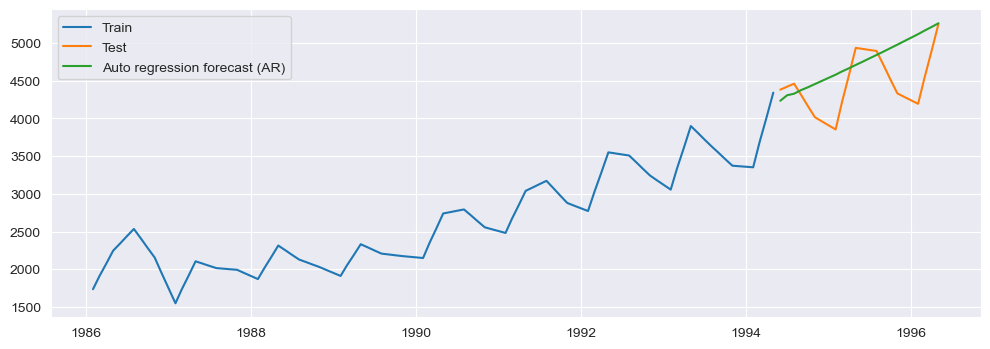

In [60]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['ar_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

## Model Evaluation
RMSE (Root Mean Squared Error)

In [61]:
from sklearn.metrics import mean_squared_error
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['ar_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

455.62

## ARIMA on the Original Data without UpSampling

In [62]:
# separate out a validation dataset
size = int(np.round(len(df1)*0.70,))

cocacola_train = df1.Sales[:size]
cocacola_validation = df1.Sales[size:]

In [63]:
model = sm.tsa.arima.ARIMA(train_data,order=(4, 1, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  100
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -558.746
Date:                Mon, 30 Oct 2023   AIC                           1135.493
Time:                        09:36:38   BIC                           1158.849
Sample:                    01-31-1986   HQIC                          1144.943
                         - 04-30-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5165      0.197      7.708      0.000       1.131       1.902
ar.L2         -0.6025      0.360     -1.672      0.095      -1.309       0.104
ar.L3         -0.2442      0.314     -0.777      0.437      -0.860       0.372
ar.L4          0.0397      0.158      0.251      0.802      -0.270       0.349
ma.L1         -0.8049      0.539     -1.492      0.136      -1.862       0.252
ma.L2          0.0364      0.140      0.260      0.795      -0.238       0.311
ma.L3         -0.8111      0.554     -1.463      0.143      -1.897       0.275
ma.L4          0.9941      0.159      6.263      0.000       0.683       1.305
sigma2      4005.5579      0.000   1.51e+07      0.000    4005.557    4005.558
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                29.62
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             0.75
Prob(H) (two-sided):                  0.33   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.79e+23. Standard errors may be unstable.
"""

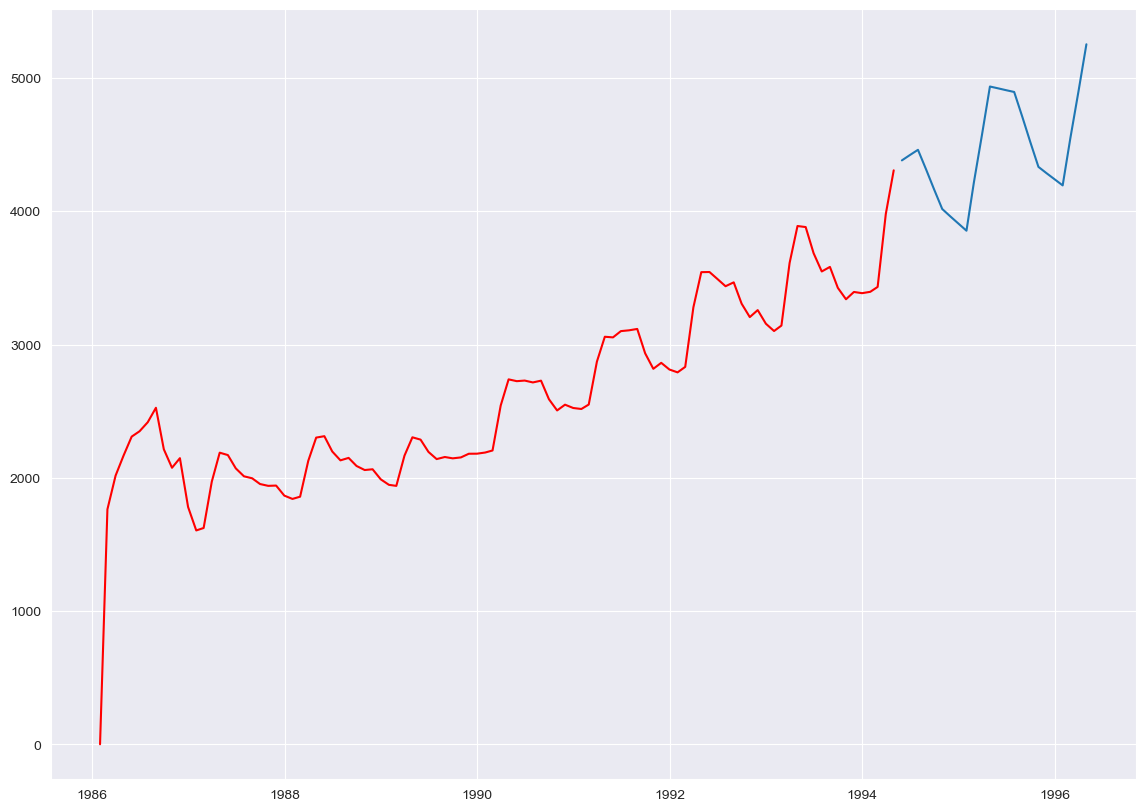

In [64]:
plt.plot(test_data)
plt.plot(results.fittedvalues,color='red')
plt.show()

## Evaluation Metric MAPE

In [65]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Simple Exponential Method

In [66]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  
ses_model = SimpleExpSmoothing(train_data["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test_data.index[0],end = test_data.index[-1])
MAPE(pred_ses,test_data.Sales) 

15.49267663292352

## Holt method

In [67]:
hw_model = Holt(train_data["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test_data.index[0],end = test_data.index[-1])
MAPE(pred_hw,test_data.Sales) 

36.224347150818495

## Holts winter exponential smoothing with additive seasonality and additive trend

In [68]:
hwe_model_add_add = ExponentialSmoothing(train_data["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test_data.index[0],end = test_data.index[-1])
MAPE(pred_hwe_add_add,test_data.Sales) 

37.82406870055411

## Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [69]:
hwe_model_mul_add = ExponentialSmoothing(train_data["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test_data.index[0],end = test_data.index[-1])
MAPE(pred_hwe_mul_add,test_data.Sales)

3.636542243525484

## Final Model by combining train and test

In [70]:
hwe_model_mul_add = ExponentialSmoothing(df["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit()

## Forecasting next 10

In [71]:
hwe_model_mul_add.forecast(10)

42    5012.344209
43    4653.573883
44    4512.618744
45    5673.548341
46    5715.159774
47    5161.415217
48    4909.552114
49    6205.541243
50    6166.703338
51    5529.963063
dtype: float64

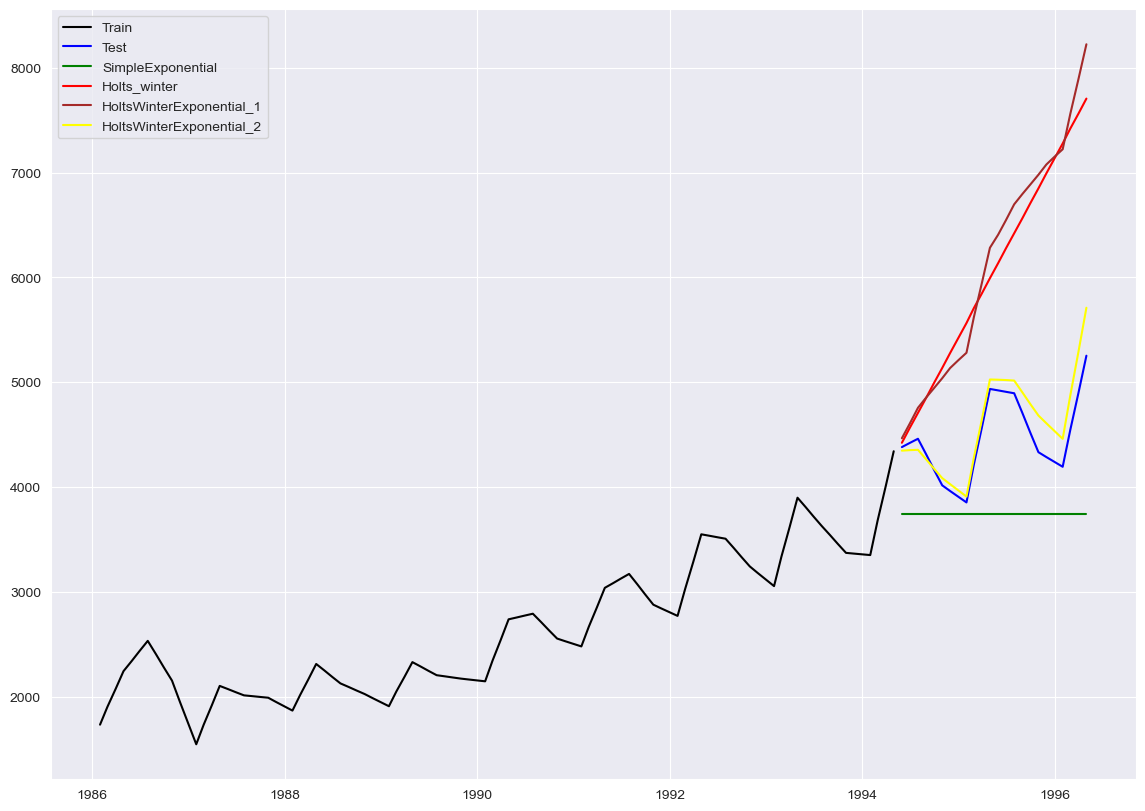

In [72]:
plt.plot(train_data.index, train_data["Sales"], label='Train',color="black")
plt.plot(test_data.index, test_data["Sales"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc='best')

## Holts winter exponential smoothing with multiplicative seasonality and additive trend model: 
   ## Best model we got with low MAPE(Mean absalute percentage error)